In [148]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import struct
from scipy.io import wavfile as wav
import IPython.display as ipd
from numpy import fft as fft
from librosa.feature import mfcc
from librosa.display import specshow

import tools as tls

import lib_read_wav as wr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature enginering for a subset of three labels

In [14]:
fs = 44100

In [157]:
def get_mini_set():
    meta = pd.read_csv('train.csv')
    meta = meta[meta.label.isin(['Oboe', 'Clarinet', 'Meow', 'Knock'])].copy()
    print('numeber of samples: {}'.format(meta.shape[0]))
    return meta.reset_index(drop=True)


In [158]:
meta = get_mini_set()

numeber of samples: 1033


In [159]:
meta.sample(4)

,fname,label,manually_verified
617,988025aa.wav,Clarinet,0
710,b021b8f1.wav,Knock,1
786,c447910b.wav,Clarinet,1
89,14d0bd27.wav,Knock,0


OK. so here's sorta balanced mini data set

In [5]:
meta.label.value_counts()

Clarinet    300
Oboe        299
Meow        155
Name: label, dtype: int64

In [6]:
fmt_data = pd.concat([meta, wr.read_fmt_data(meta)], axis=1)

#### Just length distribution of the sounds

In [7]:
label_lengths = fmt_data.groupby('label').n_samples.apply(list)

/Users/eliza/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/eliza/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/eliza/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


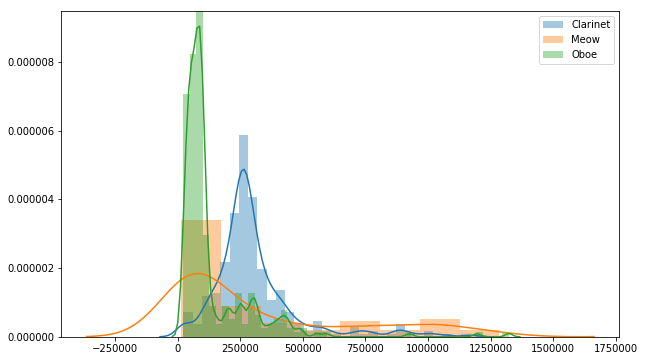

In [8]:
plt.figure(figsize=(10,6))
for i in label_lengths.index:
    sns.distplot(label_lengths.loc[i], label=i)
plt.legend()

b021b8f1.wav
Label: Knock
Number of channels: 1
Sampling rate: 44100
Bit depth: 16


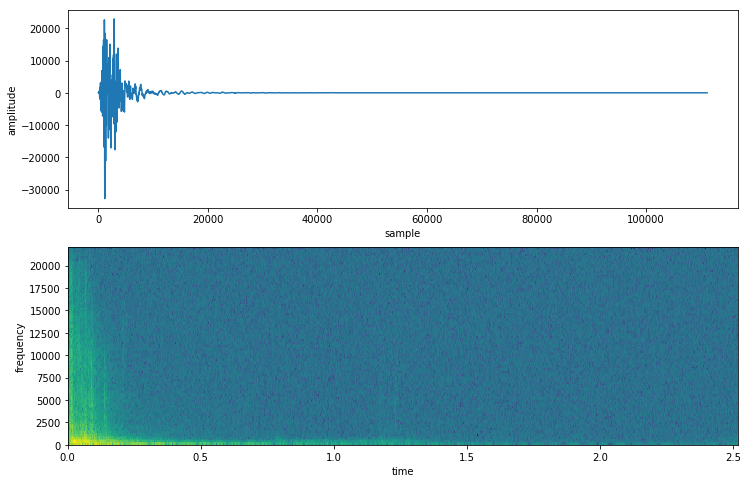

In [160]:
tst_knock = 'b021b8f1.wav'
fs, knock = wr.read_one_file(tst_knock)
wr.wav_plotter(meta, tst_knock)

6eb60c13.wav
Label: Oboe
Number of channels: 1
Sampling rate: 44100
Bit depth: 16


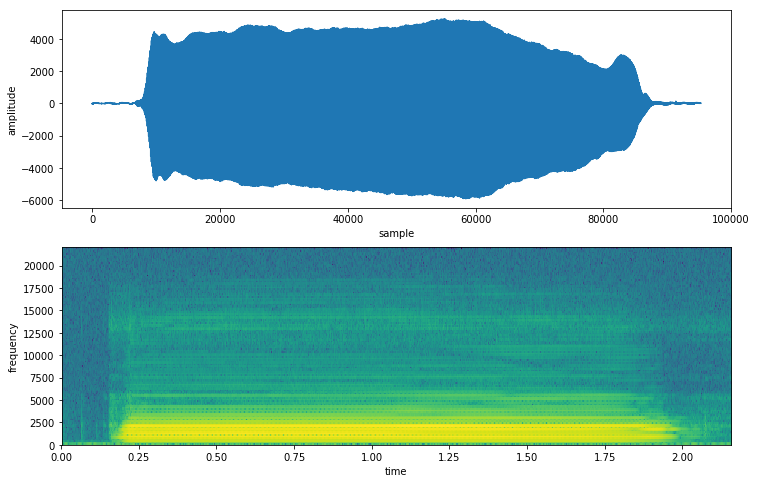

In [9]:
tst_oboe = '6eb60c13.wav'
fs, oboe = wr.read_one_file(tst_oboe)
wr.wav_plotter(meta, tst_oboe)

02d367e4.wav
Label: Clarinet
Number of channels: 1
Sampling rate: 44100
Bit depth: 16


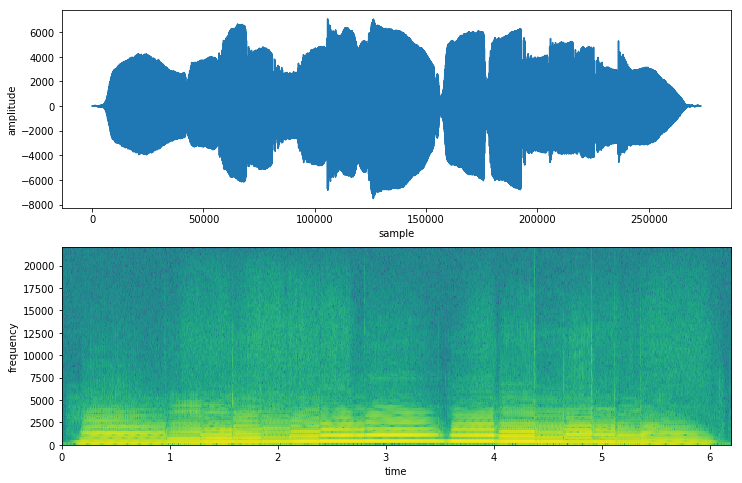

In [10]:
tst_clar = '02d367e4.wav'
fs, clar = wr.read_one_file(tst_clar)
wr.wav_plotter(meta, tst_clar)

e4f2abc5.wav
Label: Meow
Number of channels: 1
Sampling rate: 44100
Bit depth: 16


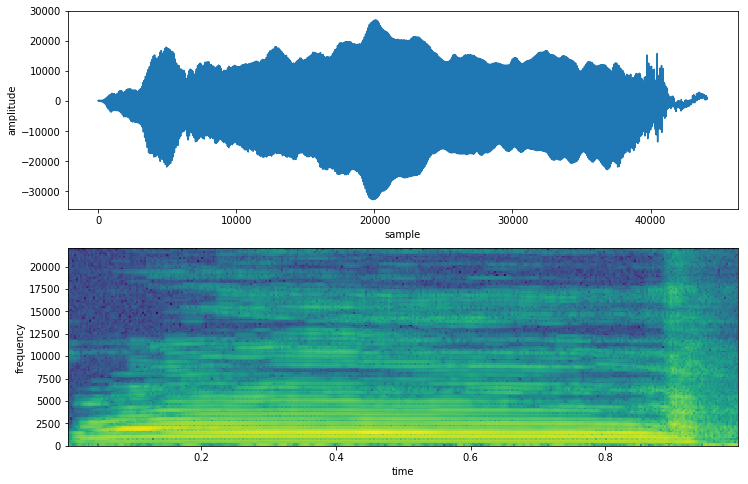

In [11]:
tst_meow = 'e4f2abc5.wav'
fs, meow = wr.read_one_file(tst_meow)
wr.wav_plotter(meta, tst_meow)

## Fourier transformation

**Wiki:** In mathematics, the discrete Fourier transform (DFT) converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency.

The standard way to do DFT is an N point FFT algorithm (fast fourier transformation). N point transformation means that it will return N first harmonics. Let us consider an example of a simple cosine wave with frequency 10 Hz.

### Sine wave

First, we defined a cosine wave and sampling frequency 20x frequency of the wave (to make in nicely smooth). Let's say the length of the sound is 2.3 second 

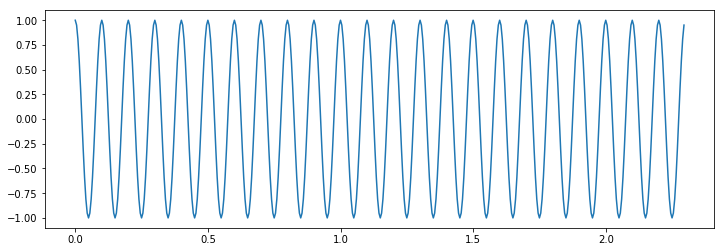

In [110]:
omega = 10
fs = omega * 20
ft = np.cos(2*omega*np.pi * np.arange(2.3* fs)/(fs))
plt.figure(figsize=(12,4))
plt.plot(np.arange(2.3*fs)/(fs),ft)

Then when we make fourier transformation in order for the transformation to return integers we'll have to make sure that the N in n point transformation must be int * fs. See for example below 2*fs point transformation

(5, 15)

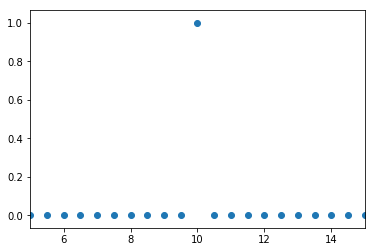

In [130]:
freqArray = np.arange(0, (2*fs), 1.0)/2 
plt.scatter(freqArray, np.absolute(fft.fft(ft, n=2*fs))/fs)
plt.xlim(5,15)

If we don't choose our N being multiple of fs, we'll have to deal with floats and this is a nasty business

(5, 15)

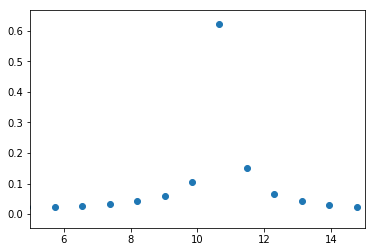

In [131]:
freqArray = np.arange(0, (1.32*fs), 1.0)/1.22
plt.scatter(freqArray, np.absolute(fft.fft(ft, n=1.32*fs))/fs)
plt.xlim(5,15)

So for our case with fs = 44100 we choos N=44100. This will contain nicely audible range of 20-20000 Hz. If we want we always can cut the range.
Below are examples of the frequencies of the 3 sounds: clarnet, oboe and meow.

I have split the sound into 0.1 sec intervals. When np.fft.fft runs of fft with the number of samples < N it pads the rest of the file with zeros

In [86]:
def do_fourier(sound_bit,fs=44100):
    cutoff = 20000
    fourier = np.absolute(fft.fft(sound_bit, n=fs)) / fs
    freqArray = np.arange(0, (fs), 1.0);
    df = pd.DataFrame([
        (x,y) for (x,y) in zip(fourier,freqArray)
    ], columns = ['power', 'frequency'])
    return df[df.frequency <= cutoff]


def plot_first_9_10th_sec_ftt(sound, freq_range=1000):
    f, axes = plt.subplots(ncols=3,nrows=3, figsize=(16,15))
    for i in range(9):
        sound_fft = do_fourier(sound[i*4410:(i+1)*4410])
        axes[i//3,i%3].plot(sound_fft.frequency[:freq_range], sound_fft.power[:freq_range])


### Clarnet

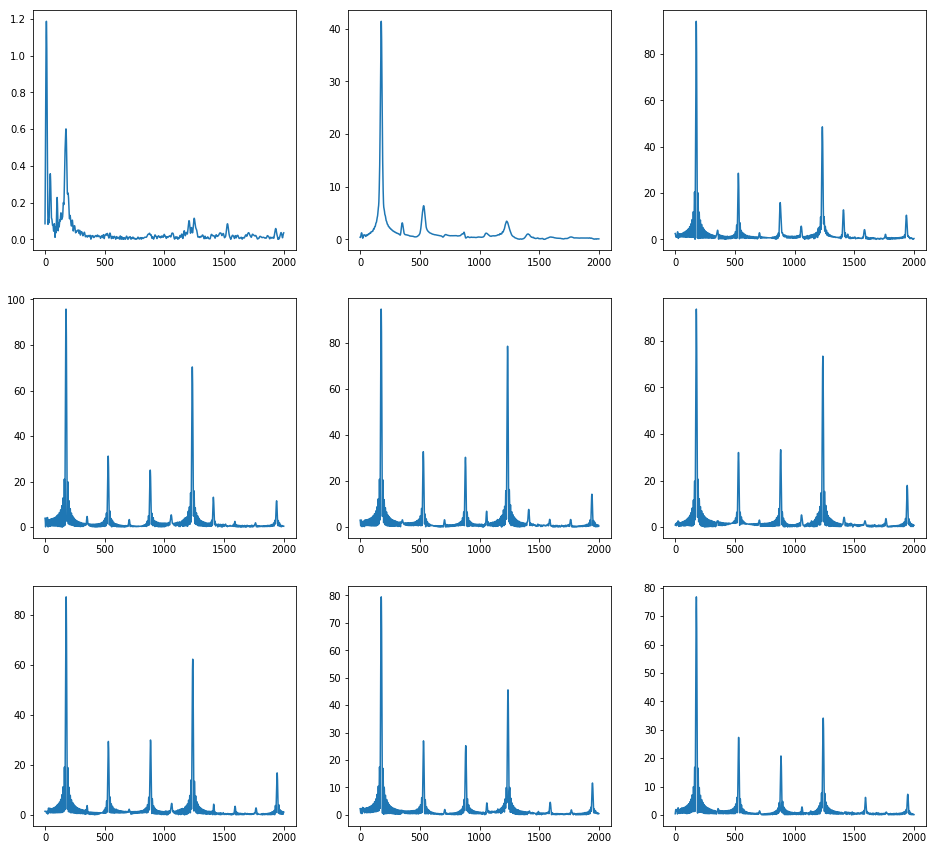

In [93]:
plot_first_9_10th_sec_ftt(clar, 2000)
plt.savefig('clarnet_fft.png')

### Oboe

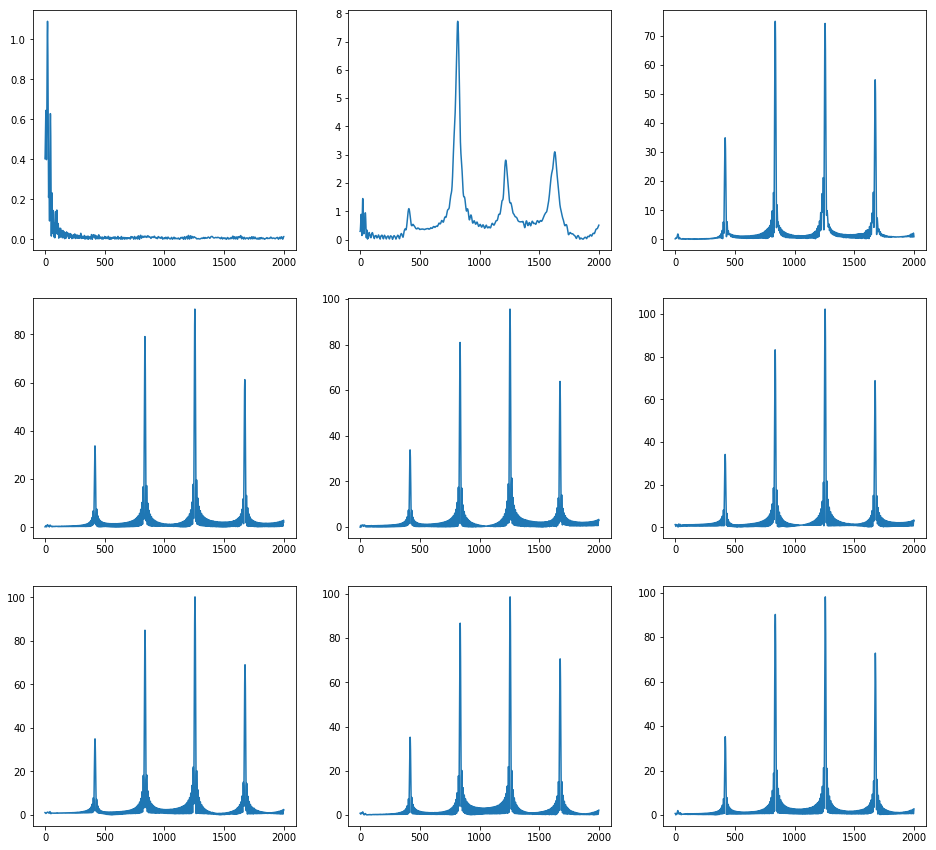

In [88]:
plot_first_9_10th_sec_ftt(oboe, 2000)

### Meow

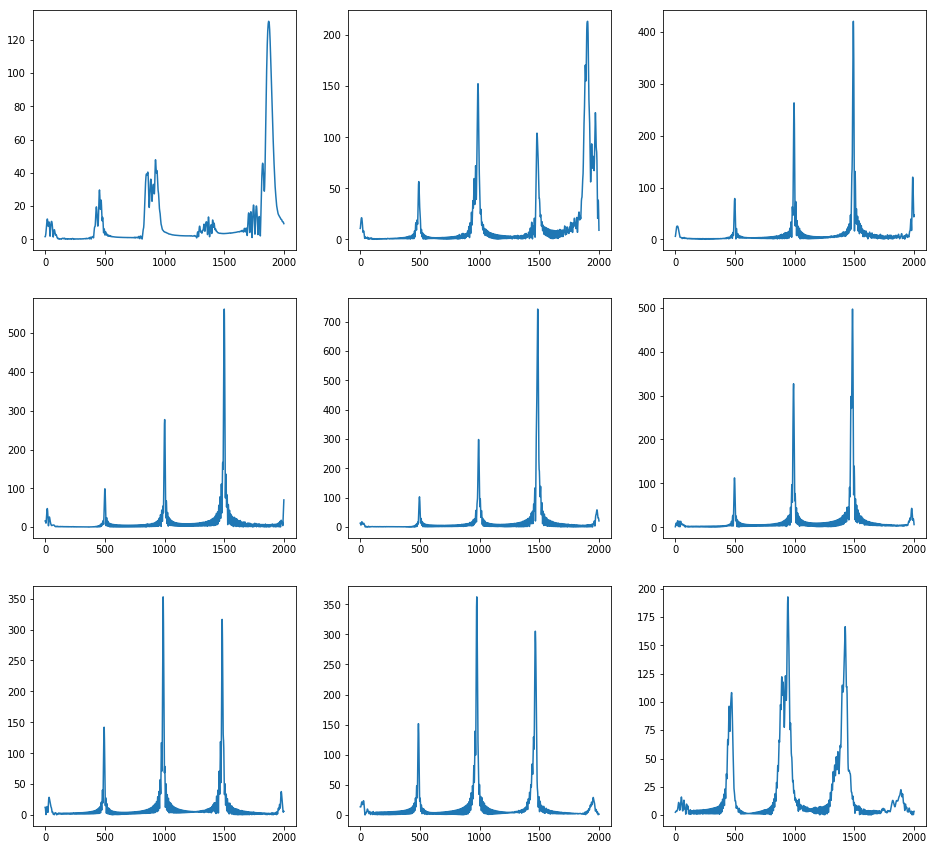

In [91]:
plot_first_9_10th_sec_ftt(meow, 2000)
plt.savefig('kitty_first9_10th_of_sec_fft.png')

Even from the beginning of the sounds we now see that meow is different from the oboe and clarnet. However pure FFT has way to many features. We have to do some feature engineering in order to actually analize the sounds.

# Feature engineering the hell out of it

## 1. Mel-frequency cepstrum coefficients (MFCCs)

Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition. They were introduced by Davis and Mermelstein in the 1980's


The **mel scale**, named by Stevens, Volkmann, and Newman in 1937,[1] is a perceptual scale of pitches judged by listeners to be equal in distance from one another.

It's very empirical and there's some criticism about its correctness.

MFCC values are not very robust in the presence of additive noise, and so it is common to normalise their values in speech recognition systems to lessen the influence of noise. Some researchers propose modifications to the basic MFCC algorithm to improve robustness

MFCCs are commonly derived as follows (http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/):
- **Frame the signal into short frames.**
    - An audio signal is constantly changing, so to simplify things we assume that on short time scales the audio signal doesn't change much (when we say it doesn't change, we mean statistically i.e. statistically stationary, obviously the samples are constantly changing on even short time scales). This is why we frame the signal into *20-40ms frames*. If the frame is much shorter we don't have enough samples to get a reliable spectral estimate, if it is longer the signal changes too much throughout the frame.
- **For each frame calculate the periodogram estimate (FFT) of the power spectrum.**
    - This is motivated by the human cochlea (an organ in the ear) which vibrates at different spots depending on the frequency of the incoming sounds. Depending on the location in the cochlea that vibrates (which wobbles small hairs), different nerves fire informing the brain that certain frequencies are present.
- **Apply the mel filterbank to the power spectra, sum the energy in each filter.**
  - the cochlea can not discern the difference between two closely spaced frequencies. This effect becomes more pronounced as the frequencies increase. For this reason we take clumps of periodogram bins and sum them up to get an idea of how much energy exists in various frequency regions. This is performed by our Mel filterbank: the first filter is very narrow and gives an indication of how much energy exists near 0 Hertz. As the frequencies get higher our filters get wider as we become less concerned about variations. We are only interested in roughly how much energy occurs at each spot. The Mel scale tells us exactly how to space our filterbanks and how wide to make them. 
- **Take the logarithm of all filterbank energies.**
  - This is also motivated by human hearing: we don't hear loudness on a linear scale. Generally to double the percieved volume of a sound we need to put 8 times as much energy into it. This means that large variations in energy may not sound all that different if the sound is loud to begin with. This compression operation makes our features match more closely what humans actually hear. Why the logarithm and not a cube root? The logarithm allows us to use cepstral mean subtraction, which is a channel normalisation technique.
- **Take the Discrete Cosine Transformation of the log filterbank energies.**
  - The final step is to compute the DCT of the log filterbank energies. There are 2 main reasons this is performed. Because our filterbanks are all overlapping, the filterbank energies are quite correlated with each other. The DCT decorrelates the energies which means diagonal covariance matrices can be used to model the features in e.g. a HMM classifier. 
- **Keep DCT coefficients 2-13, discard the rest.**
  - Only 12 of the 26 DCT coefficients are kept. This is because the higher DCT coefficients represent fast changes in the filterbank energies and it turns out that these fast changes actually degrade ASR performance, so we get a small improvement by dropping them. This holds for speech recognition, and not necessary for sound recognition
 


(20, 44)


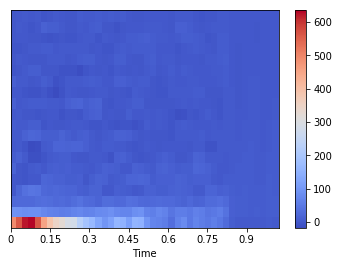

In [204]:
plt.figure(figsize=(6,4))
ns = 44100
mfcc_meow = mfcc((np.absolute(fft.fft(meow[0*ns:1*ns]))/1/ns)[:int(ns/2)], sr=44100)#,hop_length=500)
print(mfcc_meow.shape)
specshow(mfcc_meow, x_axis='time')
plt.colorbar()
#plt.imshow(mfcc_meow)

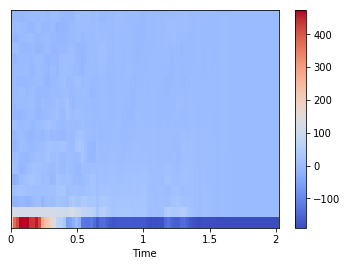

In [179]:
plt.figure(figsize=(6,4))
ns = 2*44100
mfcc_oboe = mfcc((np.absolute(fft.fft(oboe[0*ns:1*ns]))/1/ns)[:int(ns/2)], sr=44100)
specshow(mfcc_oboe, x_axis='time')
plt.colorbar()

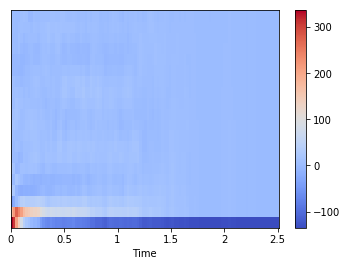

In [182]:
plt.figure(figsize=(6,4))
ns = int(2.5*44100)
mfcc_knock = mfcc((np.absolute(fft.fft(knock[0*ns:1*ns]))/1/ns)[:int(ns/2)], sr=44100)
specshow(mfcc_knock, x_axis='time')
plt.colorbar()